In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json 
import subprocess
from pprint import pprint

In [4]:
cmd = [f'g++ -o bin/monkey monkey.cpp']
p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
cout, cerr = p.communicate()
print(cout.decode(), cerr.decode())

In [24]:
config_data = {}

config_data['file_name'] = "data/monkey.csv"
config_data['reps'] = 10000
config_data['alph_size'] = 3
config_data['trial'] = '1' * config_data['alph_size']


In [25]:
cmd = ["./bin/monkey {} {} {}".format(config_data['file_name'], config_data['reps'], config_data['alph_size'])]
p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
cout, cerr = p.communicate()
print(cout.decode(), cerr.decode())

### Найдем среднее количество символов, напечатанных до получения нужной последовательности

In [26]:
df = pd.read_csv(config_data['file_name'], sep=' ')
df = df.dropna(axis=1, how='all')

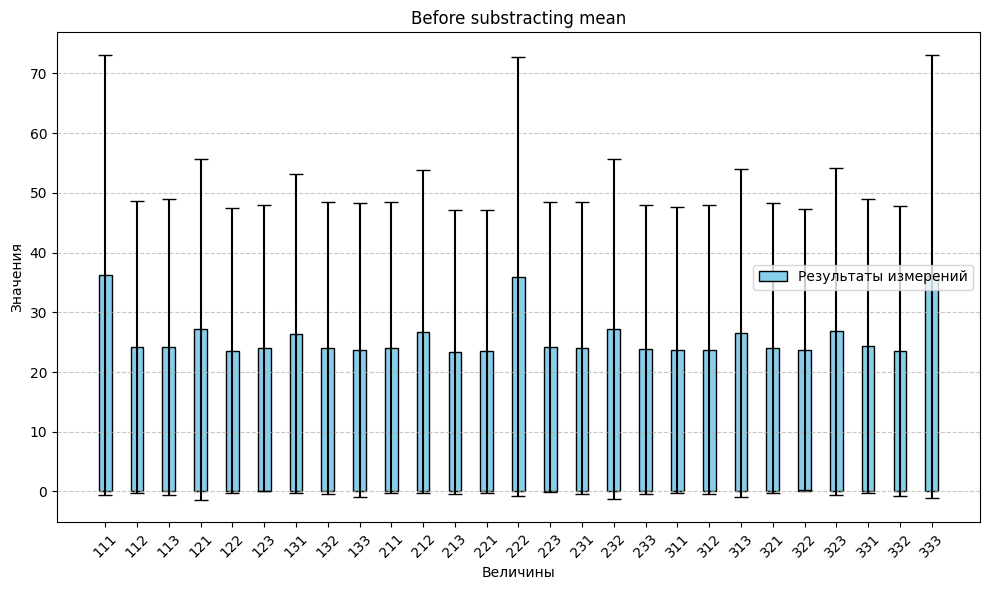

In [27]:

# Вычисляем средние значения и стандартные отклонения
for column in df.columns:
    df[column] -= config_data['alph_size']
means = df.mean()
errors = df.std(ddof=0)

# Параметры гистограммы
labels = df.columns
x = np.arange(len(labels))
width = 0.4  # Уменьшенная ширина столбцов

# Увеличиваем размер графика
plt.figure(figsize=(10, 6))

# Построение гистограммы
plt.bar(x, means, width, yerr=errors, capsize=5, color='skyblue', edgecolor='black', label='Результаты измерений')

# Настройка графика
plt.xlabel('Величины')
plt.ylabel('Значения')
plt.title('Before substracting mean')
plt.xticks(x, labels, rotation=45)  # Поворот подписей
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Автоматическая настройка отступов
plt.tight_layout()
plt.show()

### Видим, что средние количества символов для разных последовательностей отличаются, но не может этого утверждать наверняка (среднеквадратическое отклонение равно по величине среднему значению, не уменьшается в увеличением мощности выборки), исследуем плотность вероятности для случайной величины (количество напечатанных символов до получения данной последовательности)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_4724/44683588.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


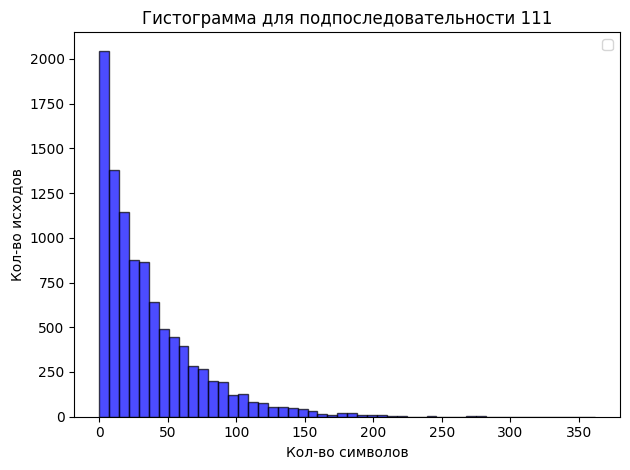

In [28]:

fig, ax = plt.subplots()

ax.hist(df[config_data['trial']], bins=50, color='blue', edgecolor='black', alpha=0.7)
bin_width = 6 / 30

ax.set_xlabel('Кол-во символов')
ax.set_ylabel('Кол-во исходов')
ax.set_title('Гистограмма для подпоследовательности {}'.format(config_data['trial']))
fig.tight_layout()
ax.legend()

fig.show()

### Эту плотность вероятности можно аппроксимировать экспонентой, на это указывает вид распределения

/tmp/ipykernel_4724/3062026104.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


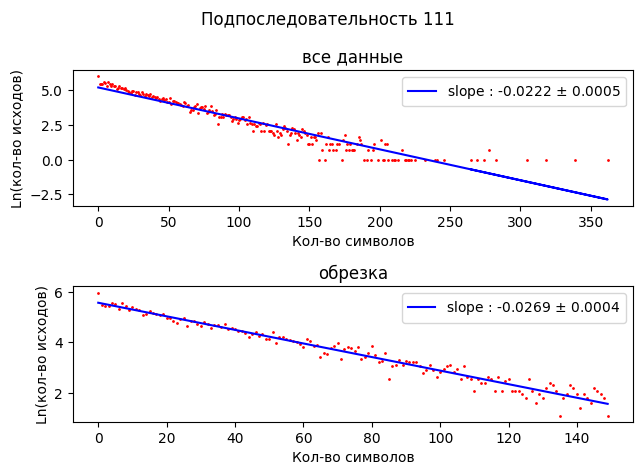

In [29]:
from scipy.optimize import curve_fit

curr = df[config_data['trial']].value_counts()
fig, axs = plt.subplots(2)

df_lin = pd.DataFrame({"index" : curr.index, "value" : curr})
df_lin["ln_value"] = np.log(curr)

def bar(x, a, b):
    return a * x + b

popt, pcov = curve_fit(bar, df_lin['index'], df_lin['ln_value'])
perr = np.sqrt(np.diag(pcov))

axs[0].scatter(df_lin['index'], df_lin['ln_value'], s=1, color='red')
axs[0].plot(df_lin['index'], bar(df_lin['index'], *popt), label=f'slope : {round(popt[0], 4)} $\\pm$ {round(perr[0], 4)}', color='blue')
axs[0].legend()
axs[0].set_title('все данные')
axs[0].set_xlabel('Кол-во символов')
axs[0].set_ylabel('Ln(кол-во исходов)')

df_lin = df_lin[df_lin['index'] < 150]
popt, pcov = curve_fit(bar, df_lin['index'], df_lin['ln_value'])
perr = np.sqrt(np.diag(pcov))

axs[1].scatter(df_lin['index'], df_lin['ln_value'], s=1, color='red')
axs[1].plot(df_lin['index'], bar(df_lin['index'], *popt), label=f'slope : {round(popt[0], 4)} $\\pm$ {round(perr[0], 4)}', color='blue')
axs[1].legend()
axs[1].set_title('обрезка')
axs[1].set_xlabel('Кол-во символов')
axs[1].set_ylabel('Ln(кол-во исходов)')

fig.suptitle('Подпоследовательность {}'.format(config_data['trial']))
fig.tight_layout()


fig.show()

### Аппросимируя плотность экспонентой, мы получили новый параметр, характеризующий случайную величину. Ошибка этого параметра зависит от мощности выборки. Теперь можно утверждать, что для разных последовательностей среднее количество напечатанных символов действительно будет разным.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


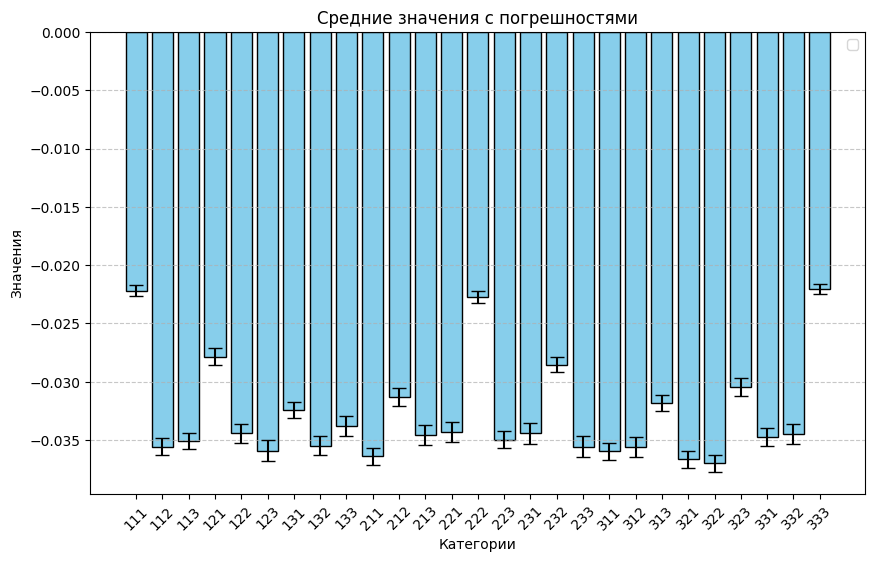

In [30]:
dct = {}

for column in df.columns:
    curr = df[column].value_counts()
    df_lin = pd.DataFrame({"index" : curr.index, "value" : curr})
    df_lin["ln_value"] = np.log(curr)

    def bar(x, a, b):
        return a * x + b

    popt, pcov = curve_fit(bar, df_lin['index'], df_lin['ln_value'])
    perr = np.sqrt(np.diag(pcov))
    
    dct[column] = [popt[0], perr[0]]

categories = list(dct.keys())
means = [value[0] for value in dct.values()]
errors = [value[1] for value in dct.values()]

plt.figure(figsize=(10, 6))
# Создаём bar plot с погрешностями
plt.bar(categories, means, yerr=errors, capsize=5, color='skyblue', edgecolor='black')

# Добавляем подписи
plt.xlabel('Категории')
plt.ylabel('Значения')
plt.title('Средние значения с погрешностями')

plt.xticks(x, labels, rotation=45)  # Поворот подписей
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Показываем график
plt.show()